## Check individual items

#### The step after EDA

#### Dataset description:
The cleaned dataset contain data from July to Sep

### Rule:
There are three rules: see below.

#### Next step: 
**Inventory Segmentation within each calss**:  (since Different items have different price, sale qty and margin rate, therefore, we should consider different weight for different group) 

In [38]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [30]:
import findspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
import re

findspark.init()

"""
Build the SparkSession
"""
# getOrCreate(): get the current Spark session or to create one if there is none running
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext # create a SparkSession object from your SparkContext

# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=local appName=Linear Regression Model>
2.4.4


In [31]:
df = spark.read.csv("../data/CleanedData/month_merge_total.csv", header=True)

In [32]:
df = df.select("SKU", 'avgNetSale', 'avgQtySold', 'avgPrice','avgSellMargin',
              'Classification', 'Facings','Capacity','month')

# clean data
# Conver columns to `FloatType()`
df = df.withColumn("avgNetSale", df.avgNetSale.cast('float')).withColumnRenamed("avgNetSale", "totalNetSale")
df = df.withColumn("avgQtySold", df.avgQtySold.cast('float')).withColumnRenamed("avgQtySold", "totalQtySold")
df = df.withColumn("avgPrice", df.avgPrice.cast('float')).withColumnRenamed("avgPrice", "totalPrice")
df = df.withColumn("avgSellMargin", df.avgSellMargin.cast('float')).withColumnRenamed("avgSellMargin", "totalSellMargin")
df = df.withColumn("Facings", df.Facings.cast('float'))
df = df.withColumn("Capacity", df.Capacity.cast('float'))

In [33]:
"""
Create new columns
"""
def calculate_overall_percentage(df, column, new_name):
    total = df.agg(sum(column)).collect()[0][0]
    df = df.withColumn(new_name, df[column]/total)
    return df


In [34]:
df = calculate_overall_percentage(df, 'totalNetSale','NS_percentage')
df = calculate_overall_percentage(df, 'totalQtySold','QtySold_percentage')
df = calculate_overall_percentage(df, 'Facings','Facing_percentage')
df = calculate_overall_percentage(df, 'Capacity','Capacity_percentage')

In [35]:
df.printSchema()

root
 |-- SKU: string (nullable = true)
 |-- totalNetSale: float (nullable = true)
 |-- totalQtySold: float (nullable = true)
 |-- totalPrice: float (nullable = true)
 |-- totalSellMargin: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- Facings: float (nullable = true)
 |-- Capacity: float (nullable = true)
 |-- month: string (nullable = true)
 |-- NS_percentage: double (nullable = true)
 |-- QtySold_percentage: double (nullable = true)
 |-- Facing_percentage: double (nullable = true)
 |-- Capacity_percentage: double (nullable = true)



In [36]:
df = df.toPandas()

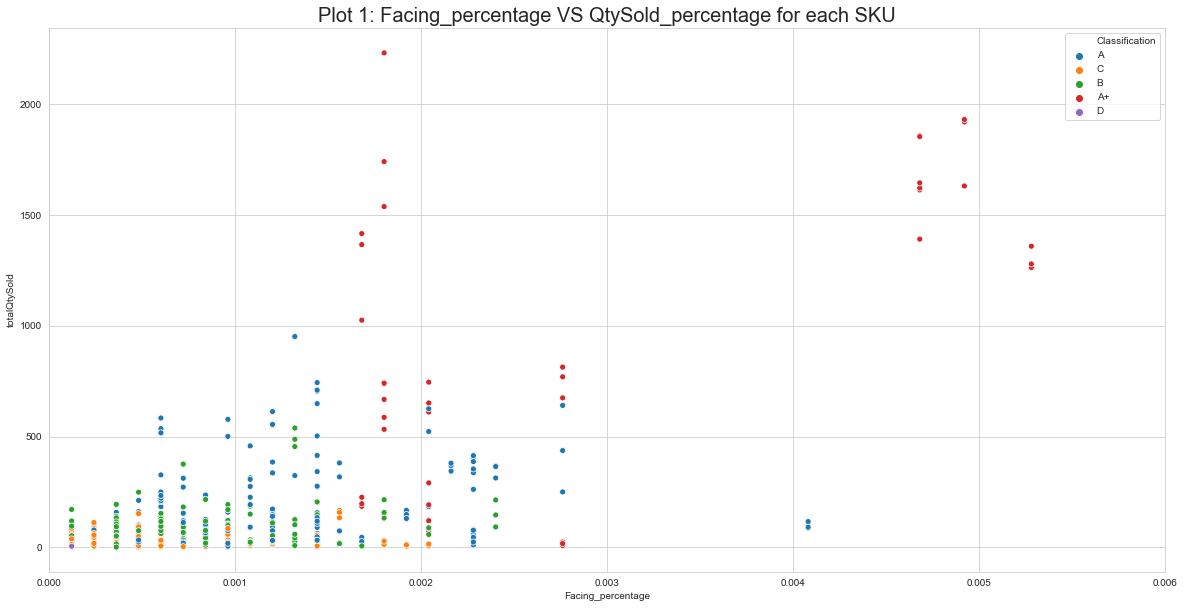

In [55]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Facing_percentage", y="totalQtySold", hue = "Classification", data=df)
ax.set_title("Plot 1: Facing_percentage VS QtySold_percentage for each SKU", fontsize=20)
plt.xlim(0,0.006)
#plt.ylim(0,0.025)
plt.show()

## Rule 1:
based on `plot 1`:

Some `A` items has relatively high facing %, but quite low sale qty, for these item, their new facing should be: <br />

**The `average facing` of items which from the same classification and has `similar price` and `similar sale qty`**.

## Rule 2: (Not sure)
based on `plot 1`:

we can also find some items with relatively low facing percentage, but quite high qty sold. Not sure if we need to increase their facing. (Some `A+` items in plot you can see)

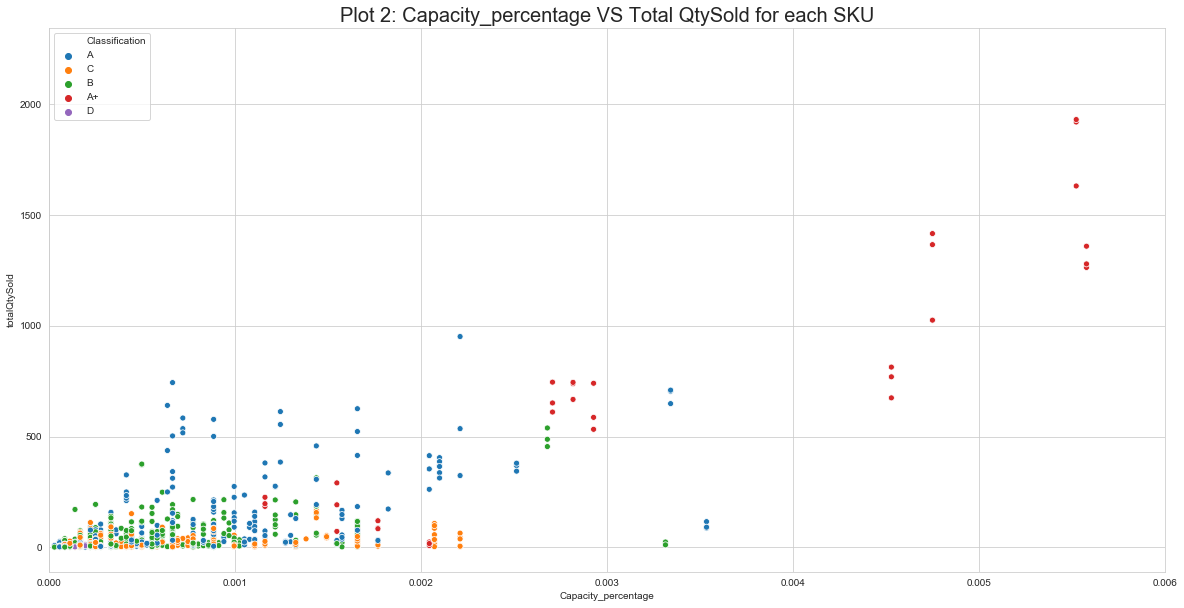

In [53]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Capacity_percentage", y="totalQtySold", hue = "Classification", data=df)
ax.set_title("Plot 2: Capacity_percentage VS Total QtySold for each SKU", fontsize=20)
plt.xlim(0,0.006)
plt.show()

## Rule 3:
based on `plot 2`:

**Adjust the capacity of items whose capacity_percentage is between 0.002 and 0.0047, and sale qty percentage < 800**

We expect lower Qty sold items, lower capacity. however, we can see that the items whose capacity percentage <=0.0047 have quite similar qty sold. Thus, I think we need to decrease the capacity of these items. 



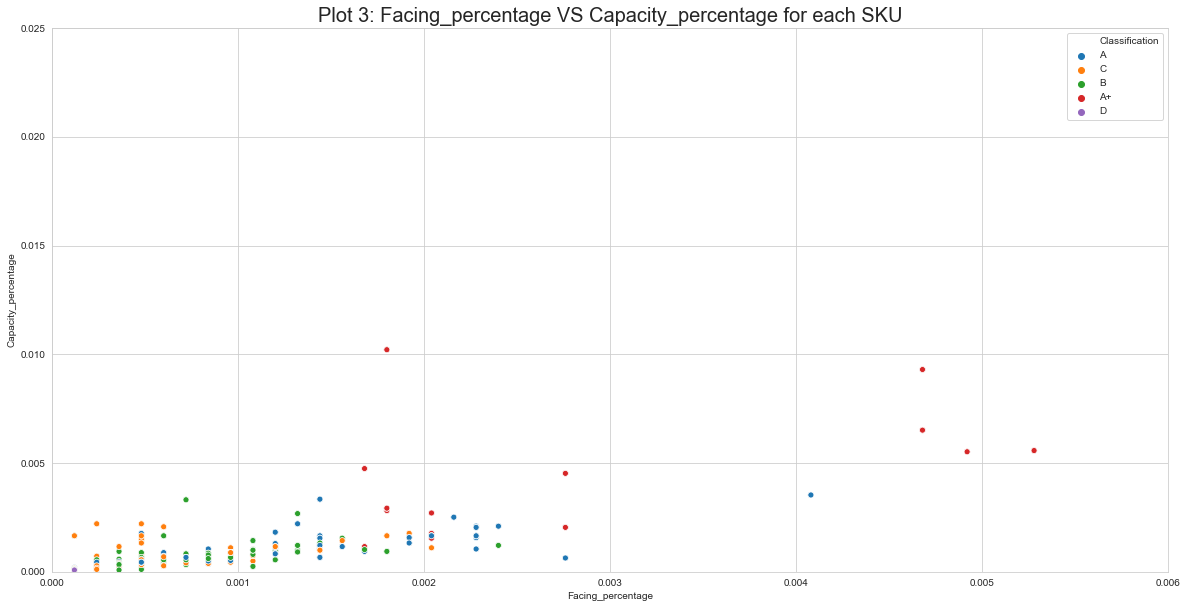

In [46]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(y="Capacity_percentage", x="Facing_percentage", hue = "Classification", data=df)
ax.set_title("Plot 3: Facing_percentage VS Capacity_percentage for each SKU", fontsize=20)
plt.xlim(0,0.006)
plt.ylim(0,0.025)
plt.show()

## Not sure what conclusion we can get from plot 3                                            